<a href="https://colab.research.google.com/github/shantanu2383/Jegadeesh-1990-/blob/main/REPLICATION_OF_JEGADEESH(1990).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Replication of "Evidence of Predictability of Security Returns" (Jegadeesh, 1990)

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)


import pandas as pd
import statsmodels.formula.api as smf 
import numpy as np 
import matplotlib.pyplot as plt

!pip install pandasql
import os
from datetime import datetime
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA 
from sklearn.metrics import mean_squared_error, mean_absolute_error 

import math
import matplotlib.pyplot as plt 
from datetime import datetime
import seaborn as sns 
import pandasql as ps

from sqlite3 import connect
conn=connect(':memory:')

# Import and Clean CRSP Monthly Data

We follow the standard process for cleaning the CRSP data. Please see 


Working with *CRSP/COMPUSTAT in R: Reproducible Empirical Asset Pricing
by Majeed Simaan* for more details

In [2]:
#Import CRSP data
filepath="/content/gdrive/MyDrive/Jegadeesh/"
file="CRSPMONTHLY.csv"
crsp=pd.read_csv(filepath + file)

crsp['date'] = pd.to_datetime(crsp['date'], format="%Y%m%d")


#parse the relevant variables

crsp_parsed=crsp[['PERMNO', 'date', 'RET', 'SHROUT', 'ALTPRC', 'EXCHCD', 'SHRCD', 'SICCD', 'DLRET', 'DLSTCD']]

crsp=crsp_parsed

#convert variables

'''
VARIABLE DICTIONARY:
PERMNO: security identifier
date: month identifier
RET: return
SHROUT: shares outstanding
ALTPRC: last traded price in a month
EXCHCD: exchange code
SHRCD: share code
SICCD: industry code
DLRET: delisting return
DLSTCD: delisting code
'''

x=['PERMNO', 'RET', 'SHROUT', 'ALTPRC', 'EXCHCD', 'SHRCD', 'SICCD', 'DLRET', 'DLSTCD']

for x in x:
  crsp[x]=pd.to_numeric(crsp[x], errors='coerce')

#convert returns to percent:
crsp['RET']*=100
crsp['DLRET']*=100


#add market cap column
crsp['mkt_cap']=abs(crsp['SHROUT'] * crsp['ALTPRC'])/1000
crsp['mkt_cap'].replace(0, np.NaN, inplace=True)

#rename variables to lower case
crsp= crsp.rename(columns=str.lower)


#filter for relevant exchanges
exchange_mapping = {
    1: 'NYSE', 31: 'NYSE',
    2: 'AMEX', 32: 'AMEX',
    3: 'NASDAQ', 33: 'NASDAQ'
}
#create dictionary to map values of the 'exchcd' column



crsp['exchange'] = np.select(
    [crsp['exchcd'].isin(exchange_mapping.keys()), crsp['exchcd'].notnull()],
    [crsp['exchcd'].map(exchange_mapping), "Other"],
    default='Other')

#only keep NYSE, AMEX and NASDAQ stocks
crsp=crsp[crsp['exchange'] == "NYSE"]

#here we modify the code to avoid looping over the entire dataframe
#we do this by creating masks which are a boolean array of true/false values
#we then use the .loc function to perform vectorised operations
crsp['ret_adj'] = crsp['ret']

mask1 = pd.isnull(crsp['dlstcd'])
crsp.loc[mask1, 'ret_adj'] = crsp.loc[mask1, 'ret']

mask2 = pd.notnull(crsp['dlstcd']) & pd.notnull(crsp['dlret'])
crsp.loc[mask2, 'ret_adj'] = crsp.loc[mask2, 'dlret']

mask3 = ((551 <= crsp['dlstcd']) & (crsp['dlstcd'] <= 574)) | (crsp['dlstcd'].isin([500, 520, 580, 584]))
crsp.loc[mask3, 'ret_adj'] = -30

crsp.loc[~(mask1 | mask2 | mask3), 'ret_adj'] = -100

crsp.drop(['shrcd', 'dlret', 'dlstcd'], inplace=True, axis=1)


#export clean crsp file

filepath="/content/gdrive/MyDrive/Jegadeesh/Clean"
#crsp.to_csv(filepath + "cleaned_crsp.csv")
crsp.to_csv(filepath + "cleaned_crsp_alternate.csv")

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (5,6,9,18,19,38,40) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
<ipython-input-2-20d9825fca7f>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crsp[x]=pd.to_numeric(crsp[x], errors='coerce')
<ipython-input-2-20d9825fca7f>:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crsp['ret_adj'] = crsp['ret']
/usr/local/lib/python3.8/di

# Table 1 Replication

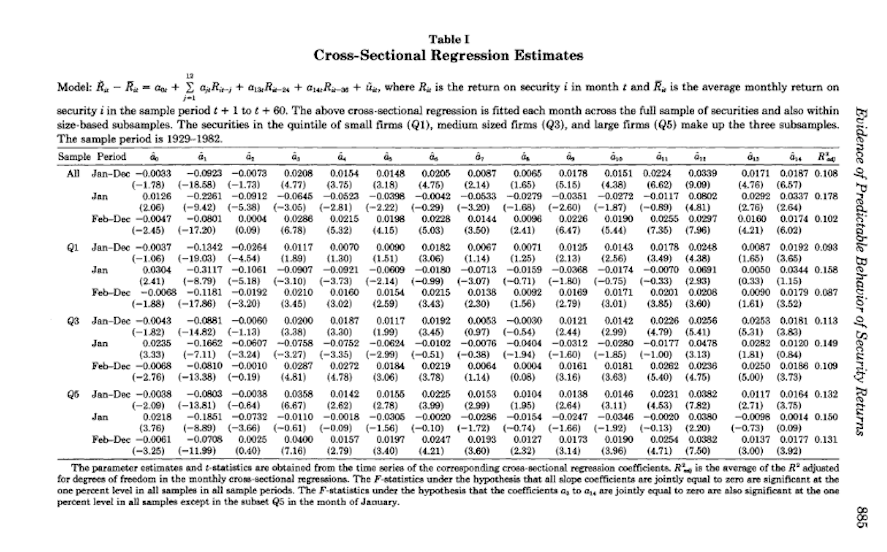

The coefficient estimates in the table above are obtained from the following cross sectional regression:

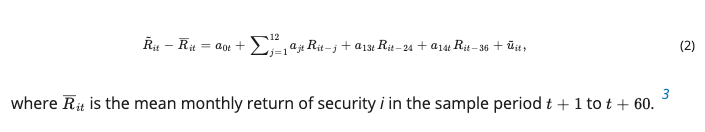

**1.1 Constructing the Relevant Variables**

In [3]:


filepath="/content/gdrive/MyDrive/Jegadeesh/Clean"
#crsp=pd.read_csv(filepath + "cleaned_crsp.csv")
crsp=pd.read_csv(filepath + "cleaned_crsp_alternate.csv")


#estimate the mean monthly return of security i in the sample period t+1 to t+60
for i in range(1,61):
  crsp[f'return_t+{i}']=crsp.groupby(['permno'])['ret_adj'].shift(-i)

crsp['fwd_exp_ret2']=crsp.iloc[:, -60:].mean(axis=1)

cols_to_drop = [f"return_t+{i}" for i in range(1, 61)]
crsp.drop(cols_to_drop, axis=1, inplace=True)

for i in [1, 2, 3, 4 , 5, 6, 7, 8, 9, 10, 11, 12, 24, 36]:
  crsp[f'return_t-{i}']=crsp.groupby(['permno'])['ret_adj'].shift(i)

crsp['ret_dep']=crsp['ret_adj']-crsp['fwd_exp_ret2']

**1.2 Model Construction**

The test period in Jegadeesh is 1929 to 1982. Since 5 years of data is needed to estimate the mean monthly return of security i in months t+1 to t+60, our sample period is 1984 to 2017

In [4]:
crsp=crsp[("1984-01-01"<=crsp['date']) & (crsp['date']< "2018-01-01")]
crsp.dropna(inplace=True)

In [5]:
#calculate 3 seperate sets of coefficients: For all months, Jan, and Feb-DEC


for x, y, z in zip(['Jan_Dec', 'Jan_only', 'Feb_Dec'], [[1,2,3,4,5,6,7,8,9,10,11,12], [1], [2,3,4,5,6,7,8,9,10,11,12]], [408, 33, 374] ):
  
  #build dataframe to store the results of coefficients for each month

  coefficient_df=pd.DataFrame(columns=['month-year', 'a0', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a7', 'a8', 'a9', 'a10', 'a11', 'a12', 'a13', 'a14', 'R^2'  ])
  crsp['date']=pd.to_datetime(crsp['date'])
  
  crsp['month_year']=crsp['date'].dt.to_period("M")
  crsp['date']=pd.to_datetime(crsp['date'])
  crsp['month']=crsp['date'].dt.month
  mask = crsp['month'].isin(y)
  crsp_temp = crsp[mask]
  grouped=crsp_temp.groupby(['month_year'])


  import statsmodels.api as sm
  for name, group in grouped:
    X=group[['return_t-1', 'return_t-2', 'return_t-3', 'return_t-4', 'return_t-5', 'return_t-6', 'return_t-7', 'return_t-8', 'return_t-9', 'return_t-10', 'return_t-11', 'return_t-12', 'return_t-24', 'return_t-36',  ]]
    y=group['ret_dep']
    X=sm.add_constant(X)
    model=sm.OLS(y, X)
    results=model.fit()
    #print(results.params)
    coefficient_df=coefficient_df.append({'month-year': str(name), 'a0': results.params[0], 'a1': results.params[1], 'a2': results.params[2], 'a3': results.params[3], 'a4': results.params[4], 'a5': results.params[5], 'a6': results.params[6], 'a7': results.params[7], 'a8': results.params[8], 'a9': results.params[9], 'a10': results.params[10], 'a11': results.params[11], 'a12': results.params[12], 'a13': results.params[13], 'a14': results.params[14], 'R^2': results.rsquared_adj }, ignore_index=True)

  coefficient_df.loc['time-series-avg']=coefficient_df.mean()
  table1=coefficient_df.loc['time-series-avg']
  table1=pd.DataFrame(table1)

  #calculate t statistics 
  coefficient_df.drop('time-series-avg', inplace=True)

  std_row=np.std(coefficient_df, axis=0)
  coefficient_df.loc[len(coefficient_df)]=std_row


  table_1_sd=coefficient_df.loc[z]
  table_1_sd=pd.DataFrame(table_1_sd)
  table1=table1.merge(table_1_sd, left_index=True, right_index=True)

  table1.rename(columns={'time-series-avg': 'coefficient', z: 'std_dev'}, inplace=True)

  table1=table1.drop('month-year')
  table1['t-statistic']=table1['coefficient']/(table1['std_dev']/np.sqrt(z))

  table1.drop(columns='std_dev', inplace=True)
  #table1=table1.drop('month-year')

  locals()["table1_all_" + x]=table1

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
<ipython-input-5-47971a170ac8>:29: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  coefficient_df.loc['time-series-avg']=coefficient_df.mean()
/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3579: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pan

**1.3 Pattern of Serial Correlation Across Different Size Groups**

From Jegadeesh (1990): The stocks in the sample are sorted on the basis of market value of equity and assigned to five size-based groups. The group Q 1 contains the quintile of small firm stocks, Q 2 contains the stocks in the next size quintile, and so on. The groups are revised every month based on firm size at the end of the previous month, and the regression model (2) is fitted within each group.

In [ ]:

#assign to relevant size quantile based on market cap. 10 portfolios in total
crsp['size_quantile']=crsp.groupby('month_year')['mkt_cap'].transform(lambda x: pd.qcut(x, 5, labels=False, duplicates='drop'))


#calculate for size quantiles Q1, Q3, Q5
for quantile, q in zip(['Q1', 'Q3', 'Q5'], [0, 2 ,4]):
  crsp_p=crsp[crsp['size_quantile']==q]
  for x, y, z in zip(['Jan_Dec', 'Jan_only', 'Feb_Dec'], [[1,2,3,4,5,6,7,8,9,10,11,12], [1], [2,3,4,5,6,7,8,9,10,11,12]], [408, 33, 374] ):
  
    #build dataframe to store the results of coefficients for each month

    coefficient_df=pd.DataFrame(columns=['month-year', 'a0', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a7', 'a8', 'a9', 'a10', 'a11', 'a12', 'a13', 'a14', 'R^2'  ])
    crsp_p['date']=pd.to_datetime(crsp_p['date'])
    
    crsp_p['month_year']=crsp_p['date'].dt.to_period("M")
    crsp_p['date']=pd.to_datetime(crsp_p['date'])
    crsp_p['month']=crsp_p['date'].dt.month
    mask = crsp_p['month'].isin(y)
    crsp_temp = crsp_p[mask]
    grouped=crsp_temp.groupby(['month_year'])


    import statsmodels.api as sm
    for name, group in grouped:
      X=group[['return_t-1', 'return_t-2', 'return_t-3', 'return_t-4', 'return_t-5', 'return_t-6', 'return_t-7', 'return_t-8', 'return_t-9', 'return_t-10', 'return_t-11', 'return_t-12', 'return_t-24', 'return_t-36',  ]]
      y=group['ret_dep']
      X=sm.add_constant(X)
      model=sm.OLS(y, X)
      results=model.fit()
      #print(results.params)
      coefficient_df=coefficient_df.append({'month-year': str(name), 'a0': results.params[0], 'a1': results.params[1], 'a2': results.params[2], 'a3': results.params[3], 'a4': results.params[4], 'a5': results.params[5], 'a6': results.params[6], 'a7': results.params[7], 'a8': results.params[8], 'a9': results.params[9], 'a10': results.params[10], 'a11': results.params[11], 'a12': results.params[12], 'a13': results.params[13], 'a14': results.params[14], 'R^2': results.rsquared_adj }, ignore_index=True)

    coefficient_df.loc['time-series-avg']=coefficient_df.mean()
    table1=coefficient_df.loc['time-series-avg']
    table1=pd.DataFrame(table1)

    #calculate t statistics 
    coefficient_df.drop('time-series-avg', inplace=True)

    std_row=np.std(coefficient_df, axis=0)
    coefficient_df.loc[len(coefficient_df)]=std_row

    print(coefficient_df)
    table_1_sd=coefficient_df.loc[z]
    table_1_sd=pd.DataFrame(table_1_sd)
    table1=table1.merge(table_1_sd, left_index=True, right_index=True)

    table1.rename(columns={'time-series-avg': 'coefficient', z: 'std_dev'}, inplace=True)

    table1=table1.drop('month-year')

    table1['t-statistic']=table1['coefficient']/(table1['std_dev']/np.sqrt(z))

    table1.drop(columns='std_dev', inplace=True)
    #table1=table1.drop('month-year')

    locals()["table1_" + quantile + "_" + x]=table1

**1.4 Construct Clean Table 1**

In [7]:
table1_all_Jan_Dec['coef_id']="all_jan_dec_coef"
table1_all_Jan_Dec['t_id']="all_jan_dec_t_stat"

table1_all_Jan_Dec.reset_index(inplace=True)

table1_all_Jan_Dec_coef=pd.pivot(table1_all_Jan_Dec, index='coef_id', columns='index', values='coefficient' )

cols=['a0', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a7', 'a8', 'a9', 'a10', 'a11', 'a12', 'a13', 'a14', 'R^2']
table1_all_Jan_Dec_coef = table1_all_Jan_Dec_coef.reindex(columns=cols)
table1_all_Jan_Dec_coef.rename_axis('id', axis=0, inplace=True)

table1_all_Jan_Dec_tstat=pd.pivot(table1_all_Jan_Dec, index='t_id', columns='index', values='t-statistic' )
cols=['a0', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a7', 'a8', 'a9', 'a10', 'a11', 'a12', 'a13', 'a14', 'R^2']
table1_all_Jan_Dec_tstat = table1_all_Jan_Dec_tstat.reindex(columns=cols)
table1_all_Jan_Dec_tstat.rename_axis('id', axis=0, inplace=True)

table_1_clean=pd.concat([table1_all_Jan_Dec_coef, table1_all_Jan_Dec_tstat ])

x=[table1_all_Feb_Dec, table1_all_Jan_only,table1_Q1_Jan_Dec, table1_Q1_Jan_only, table1_Q1_Feb_Dec, table1_Q3_Jan_Dec, table1_Q3_Jan_only, table1_Q3_Feb_Dec, table1_Q5_Jan_Dec, table1_Q5_Jan_only, table1_Q5_Feb_Dec ]
names=['all_feb_dec', 'all_jan', 'q1_all', 'q1_jan', 'q1_feb_dec', 'q3_all', 'q3_jan', 'q3_feb_dec', 'q5_all', 'q5_jan', 'q5_feb_dec' ]



for x, names in zip(x, names):
  x['coef_id']=  f"{names}_coef"
  x['t_id']=f"{names}_t_stat"

  x.reset_index(inplace=True)

  coef=pd.pivot(x, index='coef_id', columns='index', values='coefficient' )

  cols=['a0', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a7', 'a8', 'a9', 'a10', 'a11', 'a12', 'a13', 'a14', 'R^2']
  coef = coef.reindex(columns=cols)
  coef.rename_axis('id', axis=0, inplace=True)

  tstat=pd.pivot(x, index='t_id', columns='index', values='t-statistic' )
  cols=['a0', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a7', 'a8', 'a9', 'a10', 'a11', 'a12', 'a13', 'a14', 'R^2']
  tstat = tstat.reindex(columns=cols)
  tstat.rename_axis('id', axis=0, inplace=True)

  clean=pd.concat([coef, tstat])
  table_1_clean=pd.concat([table_1_clean, clean])

In [8]:
table_1_clean

index,a0,a1,a2,a3,a4,a5,a6,a7,a8,a9,a10,a11,a12,a13,a14,R^2
id,,,,,,,,,,,,,,,,
all_jan_dec_coef,-0.124504,-0.036762,-0.014488,-0.001674,-0.012172,-0.005742,-0.00028,-0.004485,-0.000273,0.006435,0.001834,0.004901,0.011605,0.013126,0.014312,0.077502
all_jan_dec_t_stat,-0.793832,-7.078889,-2.876544,-0.373949,-2.978588,-1.284087,-0.063807,-1.052971,-0.066608,1.617242,0.462411,1.202752,3.051969,4.361415,4.939755,24.26349
all_feb_dec_coef,-0.263423,-0.026956,-0.007906,0.000733,-0.008945,-0.002881,0.002796,-0.002571,0.004669,0.010447,0.004938,0.007321,0.010195,0.011936,0.01453,0.074999
all_feb_dec_t_stat,-1.628355,-5.619357,-1.624983,0.159748,-2.157608,-0.646282,0.639358,-0.609266,1.144978,2.690595,1.190716,1.843357,2.688189,3.833147,4.907602,23.372502
all_jan_coef,1.403602,-0.144627,-0.086889,-0.028158,-0.047675,-0.037205,-0.034116,-0.025533,-0.054634,-0.037692,-0.032308,-0.021714,0.027104,0.026213,0.011907,0.105029
all_jan_t_stat,5.644378,5.340756,6.838295,-124.595295,-3.01558,-22.369598,3.447199,-2.258525,8.16085,-1.588435,9.701284,-1.596768,-1.413306,3.328975,1.116159,5.373927
q1_all_coef,-0.528834,-0.062231,-0.027095,-0.012635,-0.018132,-0.013096,-0.002286,-0.019486,-0.001108,-0.002875,-0.002572,-0.010362,0.011341,0.007046,0.01119,0.107107
q1_all_t_stat,-2.895163,-8.343434,-3.896172,-1.941191,-2.884036,-1.969509,-0.344259,-2.667306,-0.183899,-0.432933,-0.430564,-1.647229,1.874632,1.254584,2.18386,28.544571
q1_jan_coef,2.281708,-0.212808,-0.117263,-0.043773,-0.059064,-0.05203,-0.047011,-0.066528,-0.06978,-0.070196,-0.060225,-0.059744,0.025806,0.048198,0.041919,0.136258


 *Our results on serial correlation are similar to Jegadeesh's findings, with a noticeable pattern present in the slope coefficients. However, we see different values for the coefficients at lags one and twelve (-.03 and 0.011, respectively), which are smaller in magnitude compared to Jegadeesh's results. Additionally, we also see high coefficients at lags twenty-four and thirty-six, similar in magnitude to the coefficient at lag twelve. Our results also suggest that coefficients a1, a2, a4, a12, a13, and a14 are all significant at the 1% level. The adjusted r-squared of our model is .078, lower compared to Jegadeesh's results.*

*The results from the sample period outside of January reveal a similar pattern of serial correlation as seen in the overall sample period. The slope coefficient at lag 1 is -0.02, while the coefficient at lag 12 is 0.0101. These coefficients, along with the coefficients at lag 24 and 36, are all significant at the 1% level. These results suggest that the returns on individual securities still exhibit significant serial correlation even when January is excluded from the sample period.*

*Our results show that when considering the month of January separately, all slope coefficients up to lag 11 are negative, while the higher order lag coefficients are positive. The significance of these coefficients, apart from lag 9, is at the 5% level. The point estimates of the coefficients at lags 12 and 24 are also around twice as large as the corresponding coefficients in other months, similar to the findings of Jegadeesh*

*We also find similar results to Jegadeesh when it comes to the pattern of serial correlation across different size groups of stocks. Like Jegadeesh, the stocks were sorted based on market value of equity and assigned to five size-based groups. During the non-January months, the pattern of serial correlation was found to be similar across all size-based quintiles. However, in January, we also found that the absolute magnitudes of the slope coefficients were generally larger for the small firm stocks, just like in Jegadeesh's findings.*

# Table 2: Prediction of Security Returns

Evaluating the significance of serial correlation through portfolio formation and abnormal return estimation

**2.1 Constructing The Relevant Variables**

We first need to construct the relevant variables which we will use to estimate abnormal returns on the portfolios:

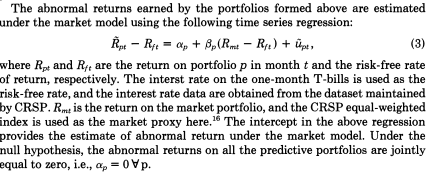

In [9]:

filepath="/content/gdrive/MyDrive/Jegadeesh/Clean"
crsp=pd.read_csv(filepath + "cleaned_crsp.csv")
crsp.dropna(inplace=True)
crsp=crsp[("1982-01-01"<=crsp['date']) & (crsp['date']<= "2021-12-31")]


**Import CRSP 1M Treasury Bill Interest Rates**

In [11]:
filepath="/content/gdrive/MyDrive/Jegadeesh/"
tb=pd.read_csv(filepath + "crsp_treasury_bills.csv")

tb=tb[tb['TTERMLBL']=="CRSP Risk Free Rates - 1-Month (Nominal)"]
tb=tb.rename(columns={"MCALDT": "date"})

tb['date']=pd.to_datetime(tb['date'], format="%Y%m%d")
crsp['date']=pd.to_datetime(crsp['date'], format="%Y-%m-%d")
tb['month_year']=tb['date'].dt.to_period("M")
crsp['month_year']=crsp['date'].dt.to_period("M")

#match interest rates to main crsp dataframe
tb['month_year']=tb['month_year'].apply(str)
crsp['month_year']=crsp['month_year'].apply(str)
crsp.to_sql('crsp', conn, if_exists='replace')
tb.to_sql('tb', conn, if_exists='replace')

query='''
      SELECT DISTINCT crsp.*, tb.TMBIDYTM as treasury_bill_interest_rate
      FROM crsp
      LEFT JOIN tb 
      ON crsp.month_year=tb.month_year
      '''
crsp_tb=pd.read_sql(query, conn)
crsp=crsp_tb

/usr/local/lib/python3.8/dist-packages/pandas/core/generic.py:2872: UserWarning: The spaces in these column names will not be changed. In pandas versions < 0.14, spaces were converted to underscores.
  sql.to_sql(


**Import CRSP Equal Weighted Index:**

In [12]:
index=pd.read_csv(filepath + "crsp_equal_weighted_index.csv")

index=index.rename(columns={'caldt': 'date', 'ewretd': 'return'})
index['date']=pd.to_datetime(index['date'], format="%Y%m%d")
index['return']*=100

index['month_year']=index['date'].dt.to_period("M")

crsp['date']=pd.to_datetime(crsp['date'], format="%Y-%m-%d")
crsp['month_year']=crsp['date'].dt.to_period("M")


index['month_year']=index['month_year'].apply(str)
crsp['month_year']=crsp['month_year'].apply(str)

crsp.to_sql('crsp', conn, if_exists='replace')
index.to_sql('idx', conn, if_exists='replace')

query='''
        SELECT DISTINCT crsp.*, idx.return
        FROM crsp
        LEFT JOIN idx ON crsp.month_year=idx.month_year
        '''

crsp_index=pd.read_sql(query, conn)

crsp=crsp_index


In [13]:
crsp.to_csv(filepath+ 'u_crsp_tbill_market_index.csv')

# Strategy S1

Under S1 the securities are ranked in ascending order on the basis of 1 month lagged returns, and securities in the top decile are assigned to P1 and so forth up to P10

In [14]:
filepath="/content/gdrive/MyDrive/Jegadeesh/"

crsp=pd.read_csv(filepath+ 'u_crsp_tbill_market_index.csv')

In [ ]:
crsp.dropna(inplace=True)



crsp['date']=pd.to_datetime(crsp['date'], format="%Y-%m-%d")
crsp['month_year']=crsp['date'].dt.to_period("M")
crsp['month']=crsp['date'].dt.month

crsp['portfolio'] = crsp.groupby(['month_year'])['return_t-1'].transform(
    lambda x: pd.qcut(x, q=10, labels=False, duplicates='drop')
)


for label, y in zip(['Jan_Dec', 'Jan_only', 'Feb_Dec'], [[1,2,3,4,5,6,7,8,9,10,11,12], [1], [2,3,4,5,6,7,8,9,10,11,12]]):
  #Build dataframe to store abnormal returns 
  abn_ret=pd.DataFrame(columns=['Portfolio', 'Abnormal Return', 't-statistic'])
  #build dataframe to store p values
  p_values=pd.DataFrame(columns=['Portfolio', 'P value'])
  mask=crsp['month'].isin(y)
  crsp_mask=crsp[mask]
  

  for p in (0, 1, 2, 3, 4, 5, 6, 7, 8, 9):
    crsp_p1=crsp_mask[crsp_mask['portfolio']==p]
    #pct=crsp_p1['ret_adj'].quantile(0.99)
    #crsp_p1['ret_adj']=crsp_p1['ret_adj'].clip(upper=pct)
    crsp_collapsed = crsp_p1.groupby(['month_year'], as_index=False).agg({'ret_adj': 'mean', 'treasury_bill_interest_rate': 'first', 'return': 'first'})

    crsp_collapsed['dep']=crsp_collapsed['ret_adj']-crsp_collapsed['treasury_bill_interest_rate']
    crsp_collapsed['exp']=crsp_collapsed['return']-crsp_collapsed['treasury_bill_interest_rate']

    crsp_collapsed['dep']/=100
    crsp_collapsed['exp']/=100

    import statsmodels.api as sm

    y=crsp_collapsed['dep']
    X=sm.add_constant(crsp_collapsed['exp'])
    
    model = sm.OLS(y, X)
    results = model.fit(cov_type='HC0')
    intercept = results.params['const']
    import scipy.stats as stats
    tvalue = results.tvalues['const']

    pvalue = 2 * (1 - stats.t.cdf(np.abs(tvalue), df=results.df_resid))


    abn_ret=abn_ret.append({'Portfolio': p, 'Abnormal Return': intercept, 't-statistic': results.tvalues[0],   }, ignore_index=True)
    p_values=p_values.append({'Portfolio': p, 'P value': pvalue }, ignore_index=True)
  
  x=[0,1,2,3,4,5,6,7,8,9]
  portfolio=["P1", "P2", "P3", "P4", "P5", "P6", "P7", "P8", "P9", "P10"]

  for x, portfolio in zip(x, portfolio):
    abn_ret.loc[abn_ret['Portfolio']==x, 'Portfolio']=portfolio

  
  
  abn_ret.set_index('Portfolio', inplace=True)
  abn_ret.rename(columns={'Abnormal Return': f'abn_ret_{label}', 't-statistic': f't_{label}'}, inplace=True)

  p_values.set_index('Portfolio', inplace=True)
  p_values.rename(columns={'P value': f'p_value{label}'}, inplace=True)

  

  locals()["S1_" + label]=abn_ret
  locals()["p_values_" + label]=p_values

abn_ret_s1=S1_Jan_Dec.merge(S1_Jan_only, left_index=True, right_index=True)
abn_ret_s1=abn_ret_s1.merge(S1_Feb_Dec, left_index=True, right_index=True)


difference = abn_ret_s1.loc['P1', ['abn_ret_Jan_Dec', 'abn_ret_Jan_only', 'abn_ret_Feb_Dec']] - abn_ret_s1.loc['P10', ['abn_ret_Jan_Dec', 'abn_ret_Jan_only', 'abn_ret_Feb_Dec']]
abn_ret_s1.loc['P1 - P10'] = difference


In [16]:
p_values_s1=p_values_Jan_Dec.merge(p_values_Jan_only, left_index=True, right_index=True)
p_values_s1=p_values_s1.merge(p_values_Feb_Dec, left_index=True, right_index=True)

p_values_s1

,p_valueJan_Dec,p_valueJan_only,p_valueFeb_Dec
Portfolio,,,
0.0,2.220446e-16,3.832821e-09,4.440892e-16
1.0,8.172135e-05,9.967506e-05,2.754494e-03
2.0,6.973864e-01,7.220821e-01,7.232499e-01
3.0,6.783373e-03,4.861372e-02,1.618612e-02
4.0,5.717258e-05,7.515586e-05,6.093761e-03
5.0,4.293783e-07,3.414235e-06,2.330239e-04
6.0,2.769051e-06,3.612452e-05,3.701820e-04
7.0,3.545626e-05,1.508578e-07,2.354872e-02
8.0,4.687203e-03,8.153187e-06,2.857014e-01


# Strategy S12

Under S12 the securities are ranked in descending order on the basis of 1 month lagged returns, and securities in the top decile are assigned to P1 and so forth up to P10.

In [ ]:
crsp['portfolio'] = crsp.groupby(['month_year'])['return_t-12'].transform(
    lambda x: pd.qcut(x, q=10, labels=False, duplicates='drop')
)


crsp.dropna(inplace=True)


crsp['date']=pd.to_datetime(crsp['date'], format="%Y-%m-%d")
crsp['month_year']=crsp['date'].dt.to_period("M")
crsp['month']=crsp['date'].dt.month




for label, y in zip(['Jan_Dec', 'Jan_only', 'Feb_Dec'], [[1,2,3,4,5,6,7,8,9,10,11,12], [1], [2,3,4,5,6,7,8,9,10,11,12]]):
  #Build dataframe to store abnormal returns 
  abn_ret=pd.DataFrame(columns=['Portfolio', 'Abnormal Return', 't-statistic'])
  #build dataframe to store p values
  p_values=pd.DataFrame(columns=['Portfolio', 'P value'])
  mask=crsp['month'].isin(y)
  crsp_mask=crsp[mask]
  #crsp_mask['ret_adj']=crsp_mask['ret_adj'].clip(upper=pct)
  for p in (0, 1, 2, 3, 4, 5, 6, 7, 8, 9):
    crsp_p1=crsp_mask[crsp_mask['portfolio']==p]
    pct=crsp_p1['ret_adj'].quantile(0.99)
    #crsp_p1['ret_adj']=crsp_p1['ret_adj'].clip(upper=pct)
    crsp_collapsed = crsp_p1.groupby(['month_year'], as_index=False).agg({'ret_adj': 'mean', 'treasury_bill_interest_rate': 'first', 'return': 'first'})

    crsp_collapsed['dep']=crsp_collapsed['ret_adj']-crsp_collapsed['treasury_bill_interest_rate']
    crsp_collapsed['exp']=crsp_collapsed['return']-crsp_collapsed['treasury_bill_interest_rate']

    crsp_collapsed['dep']/=100
    crsp_collapsed['exp']/=100

    import statsmodels.api as sm

    y=crsp_collapsed['dep']
    X=sm.add_constant(crsp_collapsed['exp'])

    model = sm.OLS(y, X)
    results = model.fit(cov_type='HC1')
    intercept = results.params['const']
    tvalue = results.tvalues['const']

    pvalue = 2 * (1 - stats.t.cdf(np.abs(tvalue), df=results.df_resid))

    abn_ret=abn_ret.append({'Portfolio': p, 'Abnormal Return': intercept, 't-statistic': results.tvalues[0]  }, ignore_index=True)
    p_values=p_values.append({'Portfolio': p, 'P value': pvalue }, ignore_index=True)
  
  x=[0,1,2,3,4,5,6,7,8,9]
  portfolio=["P1", "P2", "P3", "P4", "P5", "P6", "P7", "P8", "P9", "P10"]
  portfolio=list(reversed(portfolio))

  for x, portfolio in zip(x, portfolio):
    abn_ret.loc[abn_ret['Portfolio']==x, 'Portfolio']=portfolio

  abn_ret.set_index('Portfolio', inplace=True)
  abn_ret.rename(columns={'Abnormal Return': f'abn_ret_{label}', 't-statistic': f't_{label}'}, inplace=True)

  p_values.set_index('Portfolio', inplace=True)
  p_values.rename(columns={'P value': f'p_value{label}'}, inplace=True)


  locals()["S12_" + label]=abn_ret

abn_ret_s12=S12_Jan_Dec.merge(S12_Jan_only, left_index=True, right_index=True)
abn_ret_s12=abn_ret_s12.merge(S12_Feb_Dec, left_index=True, right_index=True)
abn_ret_s12.sort_index(inplace=True)


difference = abn_ret_s12.loc['P1', ['abn_ret_Jan_Dec', 'abn_ret_Jan_only', 'abn_ret_Feb_Dec']] - abn_ret_s12.loc['P10', ['abn_ret_Jan_Dec', 'abn_ret_Jan_only', 'abn_ret_Feb_Dec']]
abn_ret_s12.loc['P1 - P10'] = difference
print(abn_ret_s12)



In [18]:
p_values_s12=p_values_Jan_Dec.merge(p_values_Jan_only, left_index=True, right_index=True)
p_values_s12=p_values_s12.merge(p_values_Feb_Dec, left_index=True, right_index=True)

p_values_s12

,p_valueJan_Dec,p_valueJan_only,p_valueFeb_Dec
Portfolio,,,
0.0,2.220446e-16,3.832821e-09,4.440892e-16
1.0,8.172135e-05,9.967506e-05,2.754494e-03
2.0,6.973864e-01,7.220821e-01,7.232499e-01
3.0,6.783373e-03,4.861372e-02,1.618612e-02
4.0,5.717258e-05,7.515586e-05,6.093761e-03
5.0,4.293783e-07,3.414235e-06,2.330239e-04
6.0,2.769051e-06,3.612452e-05,3.701820e-04
7.0,3.545626e-05,1.508578e-07,2.354872e-02
8.0,4.687203e-03,8.153187e-06,2.857014e-01


# Strategy S0



In [19]:
filepath="/content/gdrive/MyDrive/Jegadeesh/"

crsp=pd.read_csv(filepath+ "u_crsp_tbill_market_index.csv")
crsp


,Unnamed: 0,level_0,index,Unnamed: 0.1,Unnamed: 0.1.1,permno,date,ret,shrout,altprc,...,return_t-9,return_t-10,return_t-11,return_t-12,return_t-24,return_t-36,ret_dep,month_year,treasury_bill_interest_rate,return
0,0,0,55,55,57,10001,1989-02-28 00:00:00,3.8462,998.0,6.75000,...,1.9802,3.0612,-7.6296,8.0000,-7.4074,2.0408,1.610315,1989-02,7.577017,0.2988
1,1,1,56,56,58,10001,1989-03-31 00:00:00,1.7778,998.0,6.75000,...,-1.2039,1.9802,3.0612,-7.6296,3.6800,2.5200,-0.421312,1989-03,8.795936,1.8060
2,2,2,57,57,59,10001,1989-04-28 00:00:00,7.4074,998.0,7.25000,...,3.0000,-1.2039,1.9802,3.0612,-3.9216,0.9901,5.573292,1989-04,8.581290,2.9089
3,3,3,58,58,60,10001,1989-05-31 00:00:00,-3.4483,998.0,7.00000,...,2.9126,3.0000,-1.2039,1.9802,-7.1429,-0.9804,-5.452875,1989-05,8.603763,2.5054
4,4,4,59,59,61,10001,1989-06-30 00:00:00,1.7143,1001.0,7.00000,...,-2.1132,2.9126,3.0000,-1.2039,5.1429,-1.3069,-0.440540,1989-06,8.274726,-0.7744
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2452037,2452037,2452037,4560700,4560700,4895916,93436,2021-08-31 00:00:00,7.0605,1001767.0,735.71997,...,46.2736,-9.5499,-13.9087,74.1452,-6.6222,1.1806,17.675471,2021-08,0.045626,2.0293
2452038,2452038,2452038,4560701,4560701,4895917,93436,2021-09-30 00:00:00,5.4042,1004000.0,775.47998,...,24.3252,46.2736,-9.5499,-13.9087,6.7639,-12.2290,18.689033,2021-09,0.050696,-2.8795
2452039,2452039,2452039,4560702,4560702,4895918,93436,2021-10-29 00:00:00,43.6530,1004265.0,1114.00000,...,12.4506,24.3252,46.2736,-9.5499,30.7427,27.4011,68.325400,2021-10,0.055765,2.4655
2452040,2452040,2452040,4560703,4560703,4895919,93436,2021-11-30 00:00:00,2.7612,1004265.0,1144.76001,...,-14.8740,12.4506,24.3252,46.2736,4.7695,3.9013,34.292000,2021-11,0.086184,-5.1754


In [20]:
crsp.drop('index', axis=1, inplace=True)
crsp['date']=pd.to_datetime(crsp['date'])
crsp['month_year']=crsp['date'].dt.to_period("M")

unique_dates=crsp['month_year'].unique()

unique_dates=sorted(unique_dates)
unique_dates

unique_dates = [x for x in unique_dates if x>(pd.to_datetime("1933-12",  format="%Y-%m").to_period("M"))]


In [ ]:
final_df=pd.DataFrame(columns=['month-year', 'a0', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a7', 'a8', 'a9', 'a10', 'a11', 'a12', 'a13', 'a14' ])
from dateutil.relativedelta import relativedelta


for item in unique_dates:
  month_year=str(item)
  month_year=pd.to_datetime(month_year)

  start_month = (pd.to_datetime((month_year - relativedelta(months=60)).strftime("%Y-%m"), format="%Y-%m")).to_period("M")
  end_month = (pd.to_datetime((month_year - relativedelta(months=1)).strftime("%Y-%m"), format="%Y-%m")).to_period("M")
  crsp_temp=crsp[(crsp['month_year']>=start_month) & (crsp['month_year']<=end_month)]

  coefficient_df=pd.DataFrame(columns=['month-year', 'a0', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a7', 'a8', 'a9', 'a10', 'a11', 'a12', 'a13', 'a14' ])
  crsp_temp.dropna(inplace=True)
  grouped=crsp_temp.groupby(['month_year'])
  #crsp_temp.dropna(inplace=True)
  #print(crsp_temp)
  
  import statsmodels.api as sm
  for name, group in grouped:
    
    X=group[['return_t-1', 'return_t-2', 'return_t-3', 'return_t-4', 'return_t-5', 'return_t-6', 'return_t-7', 'return_t-8', 'return_t-9', 'return_t-10', 'return_t-11', 'return_t-12', 'return_t-24', 'return_t-36']]
    y=group['ret_adj']
    X=sm.add_constant(X)
    model=sm.OLS(y, X)
    results=model.fit()
    coefficient_df=coefficient_df.append({'month-year': str(name), 'a0': results.params[0], 'a1': results.params[1], 'a2': results.params[2], 'a3': results.params[3], 'a4': results.params[4], 'a5': results.params[5], 'a6': results.params[6], 'a7': results.params[7], 'a8': results.params[8], 'a9': results.params[9], 'a10': results.params[10], 'a11': results.params[11], 'a12': results.params[12], 'a13': results.params[13], 'a14': results.params[14]}, ignore_index=True)
    
  
  coefficient_df.loc['time-series-avg']=coefficient_df.mean()
  coefficient_df.at['time-series-avg', 'month-year'] = str(item)
  final_df = final_df.append(coefficient_df.loc['time-series-avg'], ignore_index=True)

  print(item)


In [22]:
final_df.to_csv(filepath + "out of sample coefficients.csv")
crsp.to_csv(filepath+"s0.crsp.csv")

In [23]:
filepath="/content/gdrive/MyDrive/Jegadeesh/"

out_of_sample=pd.read_csv(filepath + "out of sample coefficients.csv")
crsp=pd.read_csv(filepath+"s0.crsp.csv")
crsp.dropna(inplace=True)

#match out of sample coefficients to main dataframe
#out_of_sample.drop('Unnamed: 0', axis=1, inplace=True)
#crsp.drop('Unnamed: 0', axis=1, inplace=True)
out_of_sample.rename(columns={'month-year': 'month_year'}, inplace=True)
crsp.to_sql('crsp', conn, if_exists='replace')
out_of_sample.to_sql('out_of_sample', conn, if_exists='replace')


query='''SELECT DISTINCT crsp.*, o.a0, o.a1, o.a2, o.a3, o.a4, o.a5, o.a6, o.a7, o.a8, o.a9, o.a10, o.a11, o.a12, o.a13, o.a14
          FROM crsp
          LEFT JOIN out_of_sample o
          ON crsp.month_year=o.month_year'''

crsp_out_of_sample=pd.read_sql(query, conn)

crsp=crsp_out_of_sample



/usr/local/lib/python3.8/dist-packages/pandas/core/generic.py:2872: UserWarning: The spaces in these column names will not be changed. In pandas versions < 0.14, spaces were converted to underscores.
  sql.to_sql(


In [24]:
crsp=crsp[("1982-01-01"<=crsp['date']) & (crsp['date']<= "2021-12-31")]
#obtain out of sample forecasts


crsp['ret_forecast']=crsp['a0']+ (crsp['a1']*crsp['return_t-1']) + crsp['a2'] * crsp['return_t-2'] + (crsp['a3'] * crsp['return_t-3']) + (crsp['a4'] * crsp['return_t-4']) + (crsp['a5'] * crsp['return_t-5']) + (crsp['a6'] * crsp['return_t-6']) + (crsp['a7']*crsp['return_t-7']) + (crsp['a8'] * crsp['return_t-8']) + (crsp['a9']*crsp['return_t-9']) + (crsp['a10']*crsp['return_t-10']) + (crsp['a11'] * crsp['return_t-11']) + (crsp['a12'] * crsp['return_t-12']) + (crsp['a13']*crsp['return_t-24']) + (crsp['a14'] * crsp['return_t-36'])

crsp.to_csv(filepath +"out_of_sample_forecasts_crsp.csv")

In [ ]:

#obtain predictive portfolios by ranking based on out of sample return forecasts
crsp['portfolio'] = crsp.groupby(['month_year'])['ret_forecast'].transform(
    lambda x: pd.qcut(x, q=10, labels=False, duplicates='drop')
)


crsp['date']=pd.to_datetime(crsp['date'], format="%Y-%m-%d")
crsp['month_year']=crsp['date'].dt.to_period("M")
crsp['month']=crsp['date'].dt.month


for label, y in zip(['Jan_Dec', 'Feb_Dec'], [[1,2,3,4,5,6,7,8,9,10,11,12], [2,3,4,5,6,7,8,9,10,11,12]]):
  abn_ret=pd.DataFrame(columns=['Portfolio', 'Abnormal Return', 't-statistic'])
  #build dataframe to store p values
  p_values=pd.DataFrame(columns=['Portfolio', 'P value'])
  mask=crsp['month'].isin(y)
  crsp_mask=crsp[mask]
  for p in (0, 1, 2, 3, 4, 5, 6, 7, 8, 9):
    crsp_p1=crsp_mask[crsp_mask['portfolio']==p]
   
    crsp_collapsed = crsp_p1.groupby(['month_year'], as_index=False).agg({'ret_adj': 'mean', 'treasury_bill_interest_rate': 'first', 'return': 'first'})

    crsp_collapsed['dep']=crsp_collapsed['ret_adj']-crsp_collapsed['treasury_bill_interest_rate']
    crsp_collapsed['exp']=crsp_collapsed['return']-crsp_collapsed['treasury_bill_interest_rate']

    crsp_collapsed['dep']/=100
    crsp_collapsed['exp']/=100

    import statsmodels.api as sm

    y=crsp_collapsed['dep']
    X=sm.add_constant(crsp_collapsed['exp'])

    model = sm.OLS(y, X)
    results = model.fit(cov_type='HC0')
    intercept = results.params['const']
    
    import scipy.stats as stats
    tvalue = results.tvalues['const']

    pvalue = 2 * (1 - stats.t.cdf(np.abs(tvalue), df=results.df_resid))
    p_values=p_values.append({'Portfolio': p, 'P value': pvalue }, ignore_index=True)
  

    abn_ret=abn_ret.append({'Portfolio': p, 'Abnormal Return': intercept, 't-statistic': results.tvalues[0]  }, ignore_index=True)

  x=[0,1,2,3,4,5,6,7,8,9]
  portfolio=["P1", "P2", "P3", "P4", "P5", "P6", "P7", "P8", "P9", "P10"]
  portfolio=list(reversed(portfolio))
  
  for x, portfolio in zip(x, portfolio):
    abn_ret.loc[abn_ret['Portfolio']==x, 'Portfolio']=portfolio
  
  abn_ret.set_index('Portfolio', inplace=True)
  abn_ret.rename(columns={'Abnormal Return': f'abn_ret_{label}', 't-statistic': f't_{label}'}, inplace=True)
  abn_ret.sort_index(ascending=True, inplace=True)

  p_values.set_index('Portfolio', inplace=True)
  p_values.rename(columns={'P value': f'p_value{label}'}, inplace=True)

  locals()["S0_" + label]=abn_ret
  locals()["p_values_" + label]=p_values


'''
abn_ret_s0=S0_Jan_Dec.merge(S0_Jan_only, left_index=True, right_index=True)
abn_ret_s0=abn_ret_s0.merge(S0_Feb_Dec, left_index=True, right_index=True)
abn_ret_s0.sort_index(inplace=True)


difference = abn_ret_s0.loc['P1', ['abn_ret_Jan_Dec', 'abn_ret_Jan_only', 'abn_ret_Feb_Dec']] - abn_ret_s0.loc['P10', ['abn_ret_Jan_Dec', 'abn_ret_Jan_only', 'abn_ret_Feb_Dec']]
abn_ret_s0.loc['P1 - P10'] = difference
abn_ret_s0
'''

Now we repeat the process for January seperately, as the coefficients for January are calculated using the January variables from the past 5 years:

In [ ]:
filepath="/content/gdrive/MyDrive/Jegadeesh/"

crsp=pd.read_csv(filepath+ 'u_crsp_tbill_market_index.csv')

crsp.drop(columns=['Unnamed: 0', 'level_0', 'index', 'Unnamed: 0.1', 'Unnamed: 0.1.1'], axis=1, inplace=True)


crsp['date']=pd.to_datetime(crsp['date'])
crsp['month']=crsp['date'].dt.month
crsp['year']=crsp['date'].dt.year

#keep only January
crsp=crsp[crsp['month']==1]


unique_dates=crsp['year'].unique()

unique_dates=sorted(unique_dates)

final_df=pd.DataFrame(columns=['year', 'a0', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a7', 'a8', 'a9', 'a10', 'a11', 'a12', 'a13', 'a14' ])

from dateutil.relativedelta import relativedelta

for item in unique_dates:
  year=item
  year=pd.to_datetime(year, format="%Y")

  start_year = (pd.to_datetime((year - relativedelta(years=5)).strftime("%Y"), format="%Y")).year
  end_year = (pd.to_datetime((year - relativedelta(months=1)).strftime("%Y"), format="%Y")).year
  crsp_temp=crsp[(crsp['year']>=start_year) & (crsp['year']<=end_year)]

  coefficient_df=pd.DataFrame(columns=['year', 'a0', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a7', 'a8', 'a9', 'a10', 'a11', 'a12', 'a13', 'a14' ])
  crsp_temp.dropna(inplace=True)
  grouped=crsp_temp.groupby(['year'])
  #crsp_temp.dropna(inplace=True)
  #print(crsp_temp)
  
  import statsmodels.api as sm
  for name, group in grouped:
    
    X=group[['return_t-1', 'return_t-2', 'return_t-3', 'return_t-4', 'return_t-5', 'return_t-6', 'return_t-7', 'return_t-8', 'return_t-9', 'return_t-10', 'return_t-11', 'return_t-12', 'return_t-24', 'return_t-36']]
    y=group['ret_adj']
    X=sm.add_constant(X)
    model=sm.OLS(y, X)
    results=model.fit()
    coefficient_df=coefficient_df.append({'year': str(name), 'a0': results.params[0], 'a1': results.params[1], 'a2': results.params[2], 'a3': results.params[3], 'a4': results.params[4], 'a5': results.params[5], 'a6': results.params[6], 'a7': results.params[7], 'a8': results.params[8], 'a9': results.params[9], 'a10': results.params[10], 'a11': results.params[11], 'a12': results.params[12], 'a13': results.params[13], 'a14': results.params[14]}, ignore_index=True)
    
  
  coefficient_df.loc['time-series-avg']=coefficient_df.mean()
  coefficient_df.at['time-series-avg', 'year'] = str(item)
  final_df = final_df.append(coefficient_df.loc['time-series-avg'], ignore_index=True)

  print(item)




final_df.dropna(inplace=True)

out_of_sample=final_df
crsp.to_sql('crsp', conn, if_exists='replace')
out_of_sample.to_sql('out_of_sample', conn, if_exists='replace')


query='''SELECT DISTINCT crsp.*, o.a0, o.a1, o.a2, o.a3, o.a4, o.a5, o.a6, o.a7, o.a8, o.a9, o.a10, o.a11, o.a12, o.a13, o.a14
          FROM crsp
          LEFT JOIN out_of_sample o
          ON crsp.year=o.year'''

crsp_out_of_sample=pd.read_sql(query, conn)
crsp=crsp_out_of_sample

crsp.isnull().sum()
crsp.dropna(inplace=True)

In [27]:
#obtain out of sample forecasts
crsp['ret_forecast']=crsp['a0']+ (crsp['a1']*crsp['return_t-1']) + crsp['a2'] * crsp['return_t-2'] + (crsp['a3'] * crsp['return_t-3']) + (crsp['a4'] * crsp['return_t-4']) + (crsp['a5'] * crsp['return_t-5']) + (crsp['a6'] * crsp['return_t-6']) + (crsp['a7']*crsp['return_t-7']) + (crsp['a8'] * crsp['return_t-8']) + (crsp['a9']*crsp['return_t-9']) + (crsp['a10']*crsp['return_t-10']) + (crsp['a11'] * crsp['return_t-11']) + (crsp['a12'] * crsp['return_t-12']) + (crsp['a13']*crsp['return_t-24']) + (crsp['a14'] * crsp['return_t-36'])

crsp['date']=pd.to_datetime(crsp['date'])
crsp['year']=crsp['date'].dt.year
#pct=crsp['ret_adj'].quantile(0.95)
#crsp['ret_adj']=crsp['ret_adj'].clip(upper=pct)

crsp['portfolio'] = crsp.groupby(['year'])['ret_forecast'].transform(
    lambda x: pd.qcut(x, q=10, labels=False, duplicates='drop')
)

crsp.to_csv(filepath+ "jan_out_of_sample_forecasts.csv")

In [ ]:
abn_ret=pd.DataFrame(columns=['Portfolio', 'Abnormal Return', 't-statistic'])
p_values=pd.DataFrame(columns=['Portfolio', 'P value'])

for x in (0, 1, 2, 3, 4, 5, 6, 7, 8, 9):
  crsp_p1=crsp[crsp['portfolio']==x]
  #pct=crsp_p1['ret_adj'].quantile(0.95)
  #lct=crsp_p1['ret_adj'].quantile(0.01)
  #crsp_p1['ret_adj']=crsp_p1['ret_adj'].clip(upper=pct)
  #crsp_p1['ret_adj']=crsp_p1['ret_adj'].clip(lower=lct)
  crsp_collapsed = crsp_p1.groupby(['year'], as_index=False).agg({'ret_adj': 'mean', 'treasury_bill_interest_rate': 'first', 'return': 'first'})

  crsp_collapsed['dep']=crsp_collapsed['ret_adj']-crsp_collapsed['treasury_bill_interest_rate']
  crsp_collapsed['exp']=crsp_collapsed['return']-crsp_collapsed['treasury_bill_interest_rate']

  crsp_collapsed['dep']/=100
  crsp_collapsed['exp']/=100

  import statsmodels.api as sm

  y=crsp_collapsed['dep']
  X=sm.add_constant(crsp_collapsed['exp'])

  model = sm.OLS(y, X)
  results = model.fit(cov_type='HC0')
  intercept = results.params['const']

  import scipy.stats as stats
  tvalue = results.tvalues['const']

  pvalue = 2 * (1 - stats.t.cdf(np.abs(tvalue), df=results.df_resid))
  p_values=p_values.append({'Portfolio': x, 'P value': pvalue }, ignore_index=True)
  

  abn_ret=abn_ret.append({'Portfolio': x, 'Abnormal Return': intercept, 't-statistic': results.tvalues[0] }, ignore_index=True)

abn_ret.rename(columns={'Abnormal Return': 'abn_ret_jan', 't-statistic': 't_jan'}, inplace=True)
x=[0,1,2,3,4,5,6,7,8,9]
portfolio=["P1", "P2", "P3", "P4", "P5", "P6", "P7", "P8", "P9", "P10"]
portfolio=list(reversed(portfolio))
for x, portfolio in zip(x, portfolio):
  abn_ret.loc[abn_ret['Portfolio']==x, 'Portfolio']=portfolio

abn_ret.set_index('Portfolio', inplace=True)
abn_ret.sort_index(ascending=True, inplace=True)
abn_ret.rename(columns={'Abnormal Return': 'abn_ret_Jan_Only', 't-statistic': 't_Jan_Only'}, inplace=True)

p_values.set_index('Portfolio', inplace=True)
p_values.rename(columns={'P value': 'p_value_Jan_Only'}, inplace=True)

S0_Jan=abn_ret
p_values_Jan=p_values

In [ ]:
abn_ret_s0=S0_Jan_Dec.merge(S0_Feb_Dec, left_index=True, right_index=True)
abn_ret_s0=abn_ret_s0.merge(S0_Jan, left_index=True, right_index=True)


difference = abn_ret_s0.loc['P1', ['abn_ret_Jan_Dec', 'abn_ret_jan', 'abn_ret_Feb_Dec']] - abn_ret_s0.loc['P10', ['abn_ret_Jan_Dec', 'abn_ret_jan', 'abn_ret_Feb_Dec']]
abn_ret_s0.loc['P1 - P10'] = difference
abn_ret_s0

In [60]:
p_values_s0=p_values_Jan_Dec.merge(p_values_Jan, left_index=True, right_index=True)
p_values_s0=p_values_s0.merge(p_values_Feb_Dec, left_index=True, right_index=True)

p_values_s1

,p_valueJan_Dec,p_valueJan_only,p_valueFeb_Dec
Portfolio,,,
0.0,2.220446e-16,3.832821e-09,4.440892e-16
1.0,8.172135e-05,9.967506e-05,2.754494e-03
2.0,6.973864e-01,7.220821e-01,7.232499e-01
3.0,6.783373e-03,4.861372e-02,1.618612e-02
4.0,5.717258e-05,7.515586e-05,6.093761e-03
5.0,4.293783e-07,3.414235e-06,2.330239e-04
6.0,2.769051e-06,3.612452e-05,3.701820e-04
7.0,3.545626e-05,1.508578e-07,2.354872e-02
8.0,4.687203e-03,8.153187e-06,2.857014e-01


# Clean Table 2

In [32]:
new_row = pd.DataFrame([["S0", "S0", "S0", "S0", "S0", "S0"]], columns=abn_ret_s0.columns)
s0_t2 = pd.concat([new_row, abn_ret_s0], axis=0)


new_row = pd.DataFrame([["S1", "S1", "S1", "S1", "S1", "S1"]], columns=abn_ret_s1.columns)
s1_t2 = pd.concat([new_row, abn_ret_s1], axis=0)

new_row = pd.DataFrame([["S12", "S12", "S12", "S12", "S12", "S12"]], columns=abn_ret_s12.columns)
s12_t2 = pd.concat([new_row, abn_ret_s12], axis=0)

table2 = s1_t2.merge(s12_t2, left_index=True, right_index=True, suffixes=("_S1", "_S12"))
table2 = table2.merge(s0_t2, left_index=True, right_index=True, suffixes=("", "_S0"))
table2

,abn_ret_Jan_Dec_S1,t_Jan_Dec_S1,abn_ret_Jan_only_S1,t_Jan_only_S1,abn_ret_Feb_Dec_S1,t_Feb_Dec_S1,abn_ret_Jan_Dec_S12,t_Jan_Dec_S12,abn_ret_Jan_only_S12,t_Jan_only_S12,abn_ret_Feb_Dec_S12,t_Feb_Dec_S12,abn_ret_Jan_Dec,t_Jan_Dec,abn_ret_Feb_Dec,t_Feb_Dec,abn_ret_jan,t_jan
0,S1,S1,S1,S1,S1,S1,S12,S12,S12,S12,S12,S12,S0,S0,S0,S0,S0,S0
P1,0.024072,8.530433,0.074253,7.60147,0.016681,8.449619,0.009405,7.035744,0.027572,5.933985,0.006722,5.916289,0.018115,9.547605,0.013405,8.633439,0.069397,7.117972
P2,0.004273,3.97359,0.014648,4.346652,0.002717,3.011001,0.003685,4.611512,0.006793,2.352731,0.003093,3.769454,0.004714,4.613269,0.00371,3.469771,0.010083,2.953031
P3,0.000298,0.389085,0.000773,0.358326,0.000288,0.354346,0.000341,0.478316,-0.004043,-1.522247,0.000929,1.245639,0.001043,1.439948,0.000928,1.223771,-0.001231,-0.535774
P4,-0.002158,-2.719138,-0.005581,-2.037439,-0.001867,-2.414035,-0.002064,-3.004303,-0.008121,-2.972757,-0.001218,-1.813865,-0.002054,-2.741644,-0.001454,-1.94668,-0.009147,-3.95111
P5,-0.003309,-4.060665,-0.01112,-4.439351,-0.002116,-2.756095,-0.003723,-5.069582,-0.014086,-5.415165,-0.002328,-3.53342,-0.003637,-5.023746,-0.002424,-3.488701,-0.013556,-4.840771
P6,-0.004259,-5.126525,-0.015516,-5.432635,-0.002672,-3.711009,-0.003617,-5.572739,-0.011067,-4.732857,-0.00275,-4.193102,-0.00431,-5.774422,-0.002899,-4.041626,-0.012933,-4.712402
P7,-0.004229,-4.744154,-0.015814,-4.677843,-0.002541,-3.588468,-0.003655,-4.371321,-0.014935,-4.878477,-0.001964,-2.99457,-0.003675,-4.519609,-0.002105,-2.660892,-0.015778,-5.111532
P8,-0.003908,-4.174731,-0.019769,-6.421011,-0.001682,-2.272359,-0.001466,-1.83552,-0.008847,-3.712436,-0.000334,-0.449741,-0.003247,-4.000517,-0.001627,-2.137909,-0.01702,-5.181944
P9,-0.003414,-2.841143,-0.019803,-5.155782,-0.001104,-1.068905,0.000149,0.192237,-0.007301,-2.999889,0.001335,1.818242,-0.001513,-1.51472,0.000019,0.018962,-0.014874,-3.823452


In Strategy S0, the abnormal return on portfolio P1 is found to be 1.8% per month, similar to Jegadeesh's results. However, the return on portfolio P10 is negative, but this finding is not statistically significant at the 5% level. When analyzing the results for January separately, the magnitudes of the abnormal returns are generally higher.

The patterns of the abnormal portfolio returns under the strategies S 1 and S 12 also closely match the pattern implied by the signs of the observed serial correlation at these lags. However, during this time period, Strategy S1 produces a higher abnormal return on the portfolio P1-P10, which differs from Jegadeesh's finding of S0 having a higher abnormal return.


# Figure 1

In [ ]:
table2

In [33]:
fig1=table2[['abn_ret_Jan_Dec', 'abn_ret_Feb_Dec', 'abn_ret_jan']]

In [34]:
fig1 = fig1.drop([0, "P1 - P10"])




for x in ['abn_ret_Jan_Dec', 'abn_ret_Feb_Dec', 'abn_ret_jan']:
  fig1[x]*=100



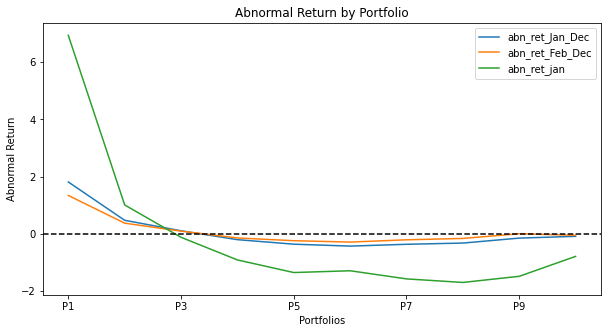

In [35]:
import matplotlib.pyplot as plt
# Plot the lines
fig1.plot(kind='line', figsize=(10,5))

# Add a horizontal line at y=0
plt.axhline(y=0, color='black', linestyle='--')

# Add labels and title
plt.xlabel("Portfolios")
plt.ylabel("Abnormal Return")
plt.title("Abnormal Return by Portfolio")

# Show the plot
plt.show()

# Table 3

In this section we calculate the propotion of positive abnormal returns on the predictive portfolios

In [36]:
filepath="/content/gdrive/MyDrive/Jegadeesh/"

crsp=pd.read_csv(filepath +"out_of_sample_forecasts_crsp.csv")
crsp.drop(columns=['Unnamed: 0', "index"], axis=1, inplace=True)

In [38]:
crsp['date']=pd.to_datetime(crsp['date'], format="%Y-%m-%d")
crsp['month_year']=crsp['date'].dt.to_period("M")
crsp['month']=crsp['date'].dt.month


#obtain predictive portfolios by ranking based on out of sample return forecasts
crsp['portfolio'] = crsp.groupby(['month_year'])['ret_forecast'].transform(
    lambda x: pd.qcut(x, q=10, labels=False, duplicates='drop')
)

for label, y in zip(['Jan_Dec', 'Feb_Dec'], [[1,2,3,4,5,6,7,8,9,10,11,12], [2,3,4,5,6,7,8,9,10,11,12]]):

  proportions_df=pd.DataFrame(columns=['Portfolio', 'Proportion'])
  mask=crsp['month'].isin(y)
  crsp_mask=crsp[mask]
  
  for x in (0, 1, 2, 3, 4, 5, 6, 7, 8, 9):
    crsp_p1=crsp_mask[crsp_mask['portfolio']==x]
    
    crsp_collapsed = crsp_p1.groupby(['month_year'], as_index=False).agg({'ret_adj': 'mean', 'treasury_bill_interest_rate': 'first', 'return': 'first'})
    crsp_collapsed['abn_ret']=crsp_collapsed['ret_adj']-crsp_collapsed['return']
    returns_column=crsp_collapsed['abn_ret']
    proportion=(returns_column > 0).sum() / len(returns_column)

    proportions_df=proportions_df.append({'Portfolio': x, 'Proportion': proportion}, ignore_index=True)

  x=[0,1,2,3,4,5,6,7,8,9]
  portfolio=["P1", "P2", "P3", "P4", "P5", "P6", "P7", "P8", "P9", "P10"]
  portfolio=list(reversed(portfolio))
  for x, portfolio in zip(x, portfolio):
    proportions_df.loc[proportions_df['Portfolio']==x, 'Portfolio']=portfolio
  
  proportions_df.set_index('Portfolio', inplace=True)
  proportions_df.rename(columns={'Proportion': f'Proportion_{label}'})
  proportions_df.sort_index(ascending=True, inplace=True)

  locals()['S0_proportion'  + label]=proportions_df

S0 Proportions for Jan:

In [39]:
crsp=pd.read_csv(filepath+ "jan_out_of_sample_forecasts.csv")

crsp['date']=pd.to_datetime(crsp['date'], format="%Y-%m-%d")
crsp['month_year']=crsp['date'].dt.to_period("M")
crsp['month']=crsp['date'].dt.month
proportions_df=pd.DataFrame(columns=['Portfolio', 'Proportion'])

for x in (0, 1, 2, 3, 4, 5, 6, 7, 8, 9):
  crsp_p1=crsp[crsp['portfolio']==x]
    
  crsp_collapsed = crsp_p1.groupby(['year'], as_index=False).agg({'ret_adj': 'mean', 'treasury_bill_interest_rate': 'first', 'return': 'first'})
  crsp_collapsed['abn_ret']=crsp_collapsed['ret_adj']-crsp_collapsed['return']
  returns_column=crsp_collapsed['abn_ret']
  proportion=(returns_column > 0).sum() / len(returns_column)

  proportions_df=proportions_df.append({'Portfolio': x, 'Proportion': proportion}, ignore_index=True)

x=[0,1,2,3,4,5,6,7,8,9]
portfolio=["P1", "P2", "P3", "P4", "P5", "P6", "P7", "P8", "P9", "P10"]
portfolio=list(reversed(portfolio))
for x, portfolio in zip(x, portfolio):
  proportions_df.loc[proportions_df['Portfolio']==x, 'Portfolio']=portfolio

proportions_df.set_index('Portfolio', inplace=True)
proportions_df.rename(columns={'Proportion': 'Proportion_Jan'}, inplace=True)
proportions_df.sort_index(ascending=True, inplace=True)
proportions_df
S0_proportionJan=proportions_df

S0_proportionJan_Dec.rename(columns={'Proportion': 'Proportion_Jan_Dec'}, inplace=True)
S0_proportionFeb_Dec.rename(columns={'Proportion': 'Proportion_Feb_Dec'}, inplace=True)

S0_proportions=S0_proportionJan_Dec.merge(S0_proportionJan, left_index=True, right_index=True)
S0_proportions=S0_proportions.merge(S0_proportionFeb_Dec,left_index=True, right_index=True)

S0_proportions

,Proportion_Jan_Dec,Proportion_Jan,Proportion_Feb_Dec
Portfolio,,,
P1,0.630480,0.897436,0.609091
P10,0.346555,0.384615,0.345455
P2,0.613779,0.666667,0.597727
P3,0.634656,0.435897,0.631818
P4,0.565762,0.333333,0.579545
P5,0.551148,0.179487,0.581818
P6,0.515658,0.128205,0.545455
P7,0.540710,0.179487,0.570455
P8,0.467641,0.179487,0.495455


S1 Proportions:

In [40]:
filepath="/content/gdrive/MyDrive/Jegadeesh/"

crsp=pd.read_csv(filepath+ 'u_crsp_tbill_market_index.csv')

crsp.dropna(inplace=True)

In [41]:


crsp['date']=pd.to_datetime(crsp['date'], format="%Y-%m-%d")
crsp['month_year']=crsp['date'].dt.to_period("M")
crsp['month']=crsp['date'].dt.month

crsp['portfolio'] = crsp.groupby(['month_year'])['return_t-1'].transform(
    lambda x: pd.qcut(x, q=10, labels=False, duplicates='drop')
)

crsp.drop(columns=['Unnamed: 0', "index", "level_0", "Unnamed: 0.1", "Unnamed: 0.1.1"], axis=1, inplace=True)

for label, y in zip(['Jan_Dec', 'Feb_Dec', 'Jan'], [[1,2,3,4,5,6,7,8,9,10,11,12], [2,3,4,5,6,7,8,9,10,11,12], [1]]):

  proportions_df=pd.DataFrame(columns=['Portfolio', 'Proportion'])
  mask=crsp['month'].isin(y)
  crsp_mask=crsp[mask]
  
  for x in (0, 1, 2, 3, 4, 5, 6, 7, 8, 9):
    crsp_p1=crsp_mask[crsp_mask['portfolio']==x]
    
    crsp_collapsed = crsp_p1.groupby(['month_year'], as_index=False).agg({'ret_adj': 'mean', 'treasury_bill_interest_rate': 'first', 'return': 'first'})
    crsp_collapsed['abn_ret']=crsp_collapsed['ret_adj']-crsp_collapsed['return']
    returns_column=crsp_collapsed['abn_ret']
    proportion=(returns_column > 0).sum() / len(returns_column)

    proportions_df=proportions_df.append({'Portfolio': x, 'Proportion': proportion}, ignore_index=True)

  x=[0,1,2,3,4,5,6,7,8,9]
  portfolio=["P1", "P2", "P3", "P4", "P5", "P6", "P7", "P8", "P9", "P10"]
  #portfolio=list(reversed(portfolio))
  for x, portfolio in zip(x, portfolio):
    proportions_df.loc[proportions_df['Portfolio']==x, 'Portfolio']=portfolio
  
  proportions_df.set_index('Portfolio', inplace=True)
  proportions_df.rename(columns={'Proportion': f'Proportion_{label}'})
  #proportions_df.sort_index(ascending=True, inplace=True)

  locals()['S1_proportion'  + label]=proportions_df

S1_proportionJan_Dec.rename(columns={'Proportion': 'Proportion_Jan_Dec'}, inplace=True)
S1_proportionFeb_Dec.rename(columns={'Proportion': 'Proportion_Feb_Dec'}, inplace=True)
S1_proportionJan.rename(columns={'Proportion': 'Proportion_Jan'}, inplace=True)

S1_proportions=S1_proportionJan_Dec.merge(S1_proportionJan, left_index=True, right_index=True)
S1_proportions=S1_proportions.merge(S1_proportionFeb_Dec,left_index=True, right_index=True)

S1_proportions

,Proportion_Jan_Dec,Proportion_Jan,Proportion_Feb_Dec
Portfolio,,,
P1,0.604167,0.925,0.575000
P2,0.533333,0.775,0.511364
P3,0.556250,0.625,0.550000
P4,0.522917,0.400,0.534091
P5,0.543750,0.250,0.570455
P6,0.552083,0.275,0.577273
P7,0.537500,0.225,0.565909
P8,0.518750,0.100,0.556818
P9,0.483333,0.100,0.518182


S12 Proportions:

In [42]:
crsp['portfolio'] = crsp.groupby(['month_year'])['return_t-12'].transform(
    lambda x: pd.qcut(x, q=10, labels=False, duplicates='drop')
)

for label, y in zip(['Jan_Dec', 'Feb_Dec', 'Jan'], [[1,2,3,4,5,6,7,8,9,10,11,12], [2,3,4,5,6,7,8,9,10,11,12], [1]]):

  proportions_df=pd.DataFrame(columns=['Portfolio', 'Proportion'])
  mask=crsp['month'].isin(y)
  crsp_mask=crsp[mask]
  
  for x in (0, 1, 2, 3, 4, 5, 6, 7, 8, 9):
    crsp_p1=crsp_mask[crsp_mask['portfolio']==x]
    
    crsp_collapsed = crsp_p1.groupby(['month_year'], as_index=False).agg({'ret_adj': 'mean', 'treasury_bill_interest_rate': 'first', 'return': 'first'})
    crsp_collapsed['abn_ret']=crsp_collapsed['ret_adj']-crsp_collapsed['return']
    returns_column=crsp_collapsed['abn_ret']
    proportion=(returns_column > 0).sum() / len(returns_column)

    proportions_df=proportions_df.append({'Portfolio': x, 'Proportion': proportion}, ignore_index=True)

  x=[0,1,2,3,4,5,6,7,8,9]
  portfolio=["P1", "P2", "P3", "P4", "P5", "P6", "P7", "P8", "P9", "P10"]
  portfolio=list(reversed(portfolio))
  for x, portfolio in zip(x, portfolio):
    proportions_df.loc[proportions_df['Portfolio']==x, 'Portfolio']=portfolio
  
  proportions_df.set_index('Portfolio', inplace=True)
  proportions_df.rename(columns={'Proportion': f'Proportion_{label}'})
  proportions_df.sort_index(ascending=True, inplace=True)

  locals()['S12_proportion'  + label]=proportions_df

S12_proportionJan_Dec.rename(columns={'Proportion': 'Proportion_Jan_Dec'}, inplace=True)
S12_proportionFeb_Dec.rename(columns={'Proportion': 'Proportion_Feb_Dec'}, inplace=True)
S12_proportionJan.rename(columns={'Proportion': 'Proportion_Jan'}, inplace=True)

S12_proportions=S12_proportionJan_Dec.merge(S12_proportionJan, left_index=True, right_index=True)
S12_proportions=S12_proportions.merge(S12_proportionFeb_Dec,left_index=True, right_index=True)

S12_proportions

,Proportion_Jan_Dec,Proportion_Jan,Proportion_Feb_Dec
Portfolio,,,
P1,0.568750,0.925,0.536364
P10,0.447917,0.700,0.425000
P2,0.620833,0.625,0.620455
P3,0.595833,0.475,0.606818
P4,0.583333,0.375,0.602273
P5,0.533333,0.175,0.565909
P6,0.556250,0.150,0.593182
P7,0.529167,0.150,0.563636
P8,0.502083,0.275,0.522727


# Clean Table 3

In [43]:
new_row = pd.DataFrame([["S0", "S0", "S0"]], columns=S0_proportions.columns)
S0_proportions = pd.concat([new_row, S0_proportions], axis=0)

new_row = pd.DataFrame([["S1", "S1", "S1"]], columns=S1_proportions.columns)
S1_proportions = pd.concat([new_row, S1_proportions], axis=0)

new_row = pd.DataFrame([["S12", "S12", "S12"]], columns=S12_proportions.columns)
S12_proportions = pd.concat([new_row, S12_proportions], axis=0)

table3 = S1_proportions.merge(S12_proportions, left_index=True, right_index=True, suffixes=("_S1", "_S12"))
table3 = table3.merge(S0_proportions, left_index=True, right_index=True, suffixes=("", "_S0"))

table3

,Proportion_Jan_Dec_S1,Proportion_Jan_S1,Proportion_Feb_Dec_S1,Proportion_Jan_Dec_S12,Proportion_Jan_S12,Proportion_Feb_Dec_S12,Proportion_Jan_Dec,Proportion_Jan,Proportion_Feb_Dec
0,S1,S1,S1,S12,S12,S12,S0,S0,S0
P1,0.604167,0.925,0.575,0.56875,0.925,0.536364,0.63048,0.897436,0.609091
P2,0.533333,0.775,0.511364,0.620833,0.625,0.620455,0.613779,0.666667,0.597727
P3,0.55625,0.625,0.55,0.595833,0.475,0.606818,0.634656,0.435897,0.631818
P4,0.522917,0.4,0.534091,0.583333,0.375,0.602273,0.565762,0.333333,0.579545
P5,0.54375,0.25,0.570455,0.533333,0.175,0.565909,0.551148,0.179487,0.581818
P6,0.552083,0.275,0.577273,0.55625,0.15,0.593182,0.515658,0.128205,0.545455
P7,0.5375,0.225,0.565909,0.529167,0.15,0.563636,0.54071,0.179487,0.570455
P8,0.51875,0.1,0.556818,0.502083,0.275,0.522727,0.467641,0.179487,0.495455
P9,0.483333,0.1,0.518182,0.447917,0.3,0.461364,0.438413,0.205128,0.456818


The proportion of months with positive abnormal returns for portfolios P1-P10 decreases under strategies S0, S1, and S12, consistent with Jegadeesh's findings. In S0, portfolio P1 shows positive abnormal returns in 63% of months, while portfolio P10 has positive abnormal returns in only 35% of months.

# Table 5: Predictive Portfolio Abnormal Returns Under A Size Based Model

In this section we estimate the abnormal returns on the predictive portfolios under the following size-based model:

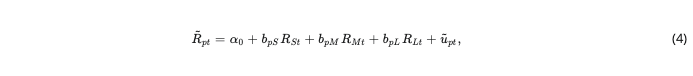

In [45]:
filepath="/content/gdrive/MyDrive/Jegadeesh/"

crsp=pd.read_csv(filepath+ 'u_crsp_tbill_market_index.csv')
crsp.drop(columns=['Unnamed: 0', 'level_0', 'index', 'Unnamed: 0.1', 'Unnamed: 0.1.1'], axis=1, inplace=True)

crsp['date']=pd.to_datetime(crsp['date'], format="%Y-%m-%d")
crsp['month_year']=crsp['date'].dt.to_period("M")
crsp['month']=crsp['date'].dt.month

crsp_size=crsp[crsp['exchange']=="NYSE"]



In [ ]:
crsp_size['size_quantile']=crsp_size.groupby('month_year')['mkt_cap'].transform(lambda x: pd.qcut(x, 3, labels=False, duplicates='drop'))

crsp_size_returns=crsp_size.groupby(['month_year', 'size_quantile'])['ret_adj'].mean().reset_index()

crsp_size_returns['size_quantile'] = np.where(crsp_size_returns['size_quantile'] == 0, 'low', 
					np.where(crsp_size_returns['size_quantile'] == 1, 'medium', 'high'))

crsp_size_returns = crsp_size_returns.pivot_table(index=['month_year'], columns='size_quantile', values='ret_adj')
crsp_size_returns

Match these portfolios back into main CRSP dataframe:

In [47]:
filepath="/content/gdrive/MyDrive/Jegadeesh/"

crsp=pd.read_csv(filepath+ 'u_crsp_tbill_market_index.csv')
crsp['date']=pd.to_datetime(crsp['date'], format="%Y-%m-%d")
crsp['month_year']=crsp['date'].dt.to_period("M")
crsp['month']=crsp['date'].dt.month

crsp.drop(columns=['Unnamed: 0', 'level_0', 'index', 'Unnamed: 0.1', 'Unnamed: 0.1.1'], axis=1, inplace=True)
#crsp_size_returns.drop(columns=['index', 'level_0'], inplace=True)
crsp['month_year']=crsp['month_year'].apply(str)
crsp_size_returns.reset_index(inplace=True)
crsp_size_returns['month_year']=crsp_size_returns['month_year'].apply(str)

crsp.to_sql('crsp', conn, if_exists='replace')
crsp_size_returns.to_sql('size', conn, if_exists='replace')

query=''' 
        SELECT crsp.*, size.high as high_portfolio_return, size.medium as medium_portfolio_return, size.low as low_portfolio_return
        FROM crsp
        LEFT JOIN size
        ON crsp.month_year=size.month_year
      '''

crsp_size=pd.read_sql(query, conn)

crsp=crsp_size

**Straetgy S1 and S12**

In [ ]:
crsp.dropna(inplace=True)
crsp=crsp[("1984-01-01"<=crsp['date']) & (crsp['date']< "2018-12-31")]


crsp['date']=pd.to_datetime(crsp['date'], format="%Y-%m-%d")
crsp['month_year']=crsp['date'].dt.to_period("M")
crsp['month']=crsp['date'].dt.month

crsp['portfolio'] = crsp.groupby(['month_year'])['return_t-12'].transform(
    lambda x: pd.qcut(x, q=10, labels=False, duplicates='drop')
)

for lag, strategy in zip(['return_t-1', 'return_t-12'], ['S1', 'S12']):
  crsp['portfolio'] = crsp.groupby(['month_year'])[lag].transform(
      lambda x: pd.qcut(x, q=10, labels=False, duplicates='drop'))
  for label, y in zip(['Jan_Dec', 'Jan_only', 'Feb_Dec'], [[1,2,3,4,5,6,7,8,9,10,11,12], [1], [2,3,4,5,6,7,8,9,10,11,12]]):
    #Build dataframe to store abnormal returns 
    abn_ret=pd.DataFrame(columns=['Portfolio', 'Abnormal Return', 't-statistic'])
    mask=crsp['month'].isin(y)
    crsp_mask=crsp[mask]

    for p in (0, 9):
      crsp_p1=crsp_mask[crsp_mask['portfolio']==p]
      pct=crsp_p1['ret_adj'].quantile(0.99)
      crsp_p1['ret_adj']=crsp_p1['ret_adj'].clip(upper=pct)
      crsp_collapsed = crsp_p1.groupby(['month_year'], as_index=False).agg({'ret_adj': 'mean', 'low_portfolio_return': 'first', 'medium_portfolio_return': 'first', 'high_portfolio_return': 'first'})
      for x in ['ret_adj', 'low_portfolio_return', 'medium_portfolio_return', 'high_portfolio_return']:
        crsp_collapsed[x]=crsp_collapsed[x]/100


      import statsmodels.api as sm
      y=crsp_collapsed['ret_adj']
      x = sm.add_constant(crsp_collapsed[['low_portfolio_return', 'medium_portfolio_return', 'high_portfolio_return']])

      model = sm.OLS(y, x)
      results = model.fit(cov_type='HC0')
      intercept = results.params['const']

      abn_ret=abn_ret.append({'Portfolio': p, 'Abnormal Return': intercept, 't-statistic': results.tvalues[0]  }, ignore_index=True)

    x=[0,9]
    portfolio=["P1", "P10"]
    if lag=="return_t-12":
      portfolio=portfolio[::-1]
      print(portfolio)
    for x, portfolio in zip(x, portfolio):
      abn_ret.loc[abn_ret['Portfolio']==x, 'Portfolio']=portfolio

    abn_ret.set_index('Portfolio', inplace=True)
    abn_ret.rename(columns={'Abnormal Return': f'abn_ret_{label}', 't-statistic': f't_{label}'}, inplace=True)

    locals()[f"{strategy}_" + label]=abn_ret

In [ ]:
abn_ret_s1=S1_Jan_Dec.merge(S1_Jan_only, left_index=True, right_index=True)
abn_ret_s1=abn_ret_s1.merge(S1_Feb_Dec, left_index=True, right_index=True)

abn_ret_s1

In [ ]:
abn_ret_S12=S12_Jan_Dec.merge(S12_Jan_only, left_index=True, right_index=True)
abn_ret_S12=abn_ret_S12.merge(S12_Feb_Dec, left_index=True, right_index=True)

abn_ret_S12

In [ ]:
filepath="/content/gdrive/MyDrive/Jegadeesh/"
crsp=pd.read_csv(filepath +"out_of_sample_forecasts_crsp.csv")


crsp['date']=pd.to_datetime(crsp['date'], format="%Y-%m-%d")
crsp['month_year']=crsp['date'].dt.to_period("M")
crsp['month']=crsp['date'].dt.month

crsp.drop(columns=['Unnamed: 0', 'level_0', 'index', 'Unnamed: 0.1', 'Unnamed: 0.1.1'], axis=1, inplace=True)
#crsp_size_returns.drop(columns=['index', 'level_0'], inplace=True)
crsp['month_year']=crsp['month_year'].apply(str)
#crsp_size_returns.reset_index(inplace=True)
crsp_size_returns['month_year']=crsp_size_returns['month_year'].apply(str)

crsp.to_sql('crsp', conn, if_exists='replace')
crsp_size_returns.to_sql('size', conn, if_exists='replace')

query=''' 
        SELECT crsp.*, size.high as high_portfolio_return, size.medium as medium_portfolio_return, size.low as low_portfolio_return
        FROM crsp
        LEFT JOIN size
        ON crsp.month_year=size.month_year
      '''

crsp_size=pd.read_sql(query, conn)

crsp=crsp_size
#obtain predictive portfolios by ranking based on out of sample return forecasts
crsp['portfolio'] = crsp.groupby(['month_year'])['ret_forecast'].transform(
    lambda x: pd.qcut(x, q=10, labels=False, duplicates='drop')
)


crsp['date']=pd.to_datetime(crsp['date'], format="%Y-%m-%d")
crsp['month_year']=crsp['date'].dt.to_period("M")
crsp['month']=crsp['date'].dt.month


for label, y in zip(['Jan_Dec',  'Feb_Dec'], [[1,2,3,4,5,6,7,8,9,10,11,12], [2,3,4,5,6,7,8,9,10,11,12]]):
  #Build dataframe to store abnormal returns 
  abn_ret=pd.DataFrame(columns=['Portfolio', 'Abnormal Return', 't-statistic'])
  mask=crsp['month'].isin(y)
  crsp_mask=crsp[mask]

  for p in (0, 9):
    crsp_p1=crsp_mask[crsp_mask['portfolio']==p]
    pct=crsp_p1['ret_adj'].quantile(0.99)
    crsp_p1['ret_adj']=crsp_p1['ret_adj'].clip(upper=pct)
    crsp_collapsed = crsp_p1.groupby(['month_year'], as_index=False).agg({'ret_adj': 'mean', 'low_portfolio_return': 'first', 'medium_portfolio_return': 'first', 'high_portfolio_return': 'first'})
    for x in ['ret_adj', 'low_portfolio_return', 'medium_portfolio_return', 'high_portfolio_return']:
      crsp_collapsed[x]=crsp_collapsed[x]/100


    import statsmodels.api as sm
    y=crsp_collapsed['ret_adj']
    x = sm.add_constant(crsp_collapsed[['low_portfolio_return', 'medium_portfolio_return', 'high_portfolio_return']])

    model = sm.OLS(y, x)
    results = model.fit()
    intercept = results.params['const']

    abn_ret=abn_ret.append({'Portfolio': p, 'Abnormal Return': intercept, 't-statistic': results.tvalues[0]  }, ignore_index=True)

  x=[9,0]
  portfolio=["P1", "P10"]

  for x, portfolio in zip(x, portfolio):
    abn_ret.loc[abn_ret['Portfolio']==x, 'Portfolio']=portfolio

  abn_ret.set_index('Portfolio', inplace=True)
  abn_ret.rename(columns={'Abnormal Return': f'abn_ret_{label}', 't-statistic': f't_{label}'}, inplace=True)

  locals()["S0_" + label]=abn_ret

In [54]:
crsp=pd.read_csv(filepath+ "jan_out_of_sample_forecasts.csv")

crsp['date']=pd.to_datetime(crsp['date'], format="%Y-%m-%d")
crsp['month_year']=crsp['date'].dt.to_period("M")
crsp['month']=crsp['date'].dt.month

crsp.drop(columns=['Unnamed: 0', 'index'], axis=1, inplace=True)
#crsp_size_returns.drop(columns=['index', 'level_0'], inplace=True)
crsp['month_year']=crsp['month_year'].apply(str)
#crsp_size_returns.reset_index(inplace=True)
crsp_size_returns['month_year']=crsp_size_returns['month_year'].apply(str)

crsp.to_sql('crsp', conn, if_exists='replace')
crsp_size_returns.to_sql('size', conn, if_exists='replace')

query=''' 
        SELECT crsp.*, size.high as high_portfolio_return, size.medium as medium_portfolio_return, size.low as low_portfolio_return
        FROM crsp
        LEFT JOIN size
        ON crsp.month_year=size.month_year
      '''

crsp_size=pd.read_sql(query, conn)

In [55]:
abn_ret=pd.DataFrame(columns=['Portfolio', 'Abnormal Return', 't-statistic'])

for p in (0, 9):
    crsp_p1=crsp_mask[crsp_mask['portfolio']==p]
    pct=crsp_p1['ret_adj'].quantile(0.99)
    crsp_p1['ret_adj']=crsp_p1['ret_adj'].clip(upper=pct)
    crsp_collapsed = crsp_p1.groupby(['month_year'], as_index=False).agg({'ret_adj': 'mean', 'low_portfolio_return': 'first', 'medium_portfolio_return': 'first', 'high_portfolio_return': 'first'})
    for x in ['ret_adj', 'low_portfolio_return', 'medium_portfolio_return', 'high_portfolio_return']:
      crsp_collapsed[x]=crsp_collapsed[x]/100


    import statsmodels.api as sm
    y=crsp_collapsed['ret_adj']
    x = sm.add_constant(crsp_collapsed[['low_portfolio_return', 'medium_portfolio_return', 'high_portfolio_return']])

    model = sm.OLS(y, x)
    results = model.fit()
    intercept = results.params['const']

    abn_ret=abn_ret.append({'Portfolio': p, 'Abnormal Return': intercept, 't-statistic': results.tvalues[0]  }, ignore_index=True)

x=[9,0]
portfolio=["P1", "P10"]

for x, portfolio in zip(x, portfolio):
  abn_ret.loc[abn_ret['Portfolio']==x, 'Portfolio']=portfolio
  
label="Jan"
abn_ret.set_index('Portfolio', inplace=True)
abn_ret.rename(columns={'Abnormal Return': f'abn_ret_{label}', 't-statistic': f't_{label}'}, inplace=True)

S0_Jan=abn_ret

abn_ret_s0=S0_Jan_Dec.merge(S0_Jan, left_index=True, right_index=True)
abn_ret_s0=abn_ret_s0.merge(S0_Feb_Dec, left_index=True, right_index=True)

abn_ret_s0

<ipython-input-55-8be0739f9c79>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crsp_p1['ret_adj']=crsp_p1['ret_adj'].clip(upper=pct)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
<ipython-input-55-8be0739f9c79>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crsp_p1['ret_adj']=crsp_p1['ret_adj'].clip(upper=pct)
/usr/local/lib/pyt

,abn_ret_Jan_Dec,t_Jan_Dec,abn_ret_Jan,t_Jan,abn_ret_Feb_Dec,t_Feb_Dec
Portfolio,,,,,,
P10,-0.006484,-3.566980,-0.005989,-2.95324,-0.005989,-2.95324
P1,0.010552,5.250233,0.003995,1.86856,0.003995,1.86856


#Clean Table 5

In [58]:
new_row = pd.DataFrame([["S0", "S0", "S0", "S0", "S0", "S0"]], columns=abn_ret_s0.columns)
S0_size_returns = pd.concat([new_row, abn_ret_s0], axis=0)


new_row = pd.DataFrame([["S1", "S1", "S1", "S1", "S1", "S1"]], columns=abn_ret_s1.columns)
S1_size_returns = pd.concat([new_row, abn_ret_s1], axis=0)

new_row = pd.DataFrame([["S12", "S12", "S12", "S12", "S12", "S12"]], columns=abn_ret_S12.columns)
S12_size_returns = pd.concat([new_row, abn_ret_S12], axis=0)


table5 = S1_size_returns.merge(S12_size_returns, left_index=True, right_index=True, suffixes=("_S1", "_S12"))
table5 = table5.merge(S0_size_returns, left_index=True, right_index=True, suffixes=("", "_S0"))
table5

,abn_ret_Jan_Dec_S1,t_Jan_Dec_S1,abn_ret_Jan_only_S1,t_Jan_only_S1,abn_ret_Feb_Dec_S1,t_Feb_Dec_S1,abn_ret_Jan_Dec_S12,t_Jan_Dec_S12,abn_ret_Jan_only_S12,t_Jan_only_S12,abn_ret_Feb_Dec_S12,t_Feb_Dec_S12,abn_ret_Jan_Dec,t_Jan_Dec,abn_ret_Jan,t_Jan,abn_ret_Feb_Dec,t_Feb_Dec
0,S1,S1,S1,S1,S1,S1,S12,S12,S12,S12,S12,S12,S0,S0,S0,S0,S0,S0
P1,0.014451,4.781803,0.048937,3.833214,0.005285,2.298262,0.003209,1.4966,0.028038,2.373923,-0.001251,-0.624335,0.010552,5.250233,0.003995,1.86856,0.003995,1.86856
P10,-0.005731,-2.622738,-0.007018,-0.875492,-0.002787,-1.162303,-0.000876,-0.453269,0.014094,1.736146,-0.001018,-0.496799,-0.006484,-3.56698,-0.005989,-2.95324,-0.005989,-2.95324


Similar to Jegadeesh's findings, under Strategy S0, the abnormal returns on the extreme decile portfolios do not differ much from the market model across all months, but in January, the returns decrease significantly. For Strategy S1, which yields higher returns in our sample, the abnormal returns on the extreme decile portfolios remain similar to the market model for all months and for January separately.